Aqui mais testes foram feitos com a ResNet50, VGG16 e DNet121, mas agora corrigindo um bug relacionado com as predicoes do modelo, que estava arredondando os resultados para 0. Isso ocorre porque a saida e sigmoid, entao estara entre 0 e 1. O python automaticamente estava arredondando tudo para zero e, por esse motivo, havia a discrepancia entre os valores do model.evaluate e o model.predict.

In [1]:
import setuptools.dist
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121, ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.pylab as plt
import pandas as pd
import os
import shutil
import numpy as np
import seaborn as sns

2024-07-01 14:44:31.670451: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 14:44:32.827866: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Função para visualização
def plot_image_counts2(folder_path):
    #Contadores pra plotar
    counts = {'cancer_type': 0, 'normal': 0}

    #Vai olhar os folders
    total_images = 0
    for class_name in counts.keys():
        class_path = os.path.join(folder_path, class_name)
        if os.path.exists(class_path):
            class_count = len(os.listdir(class_path))
            counts[class_name] = class_count
            total_images += class_count

    #Cálculo da porcentagem
    percentages = {class_name: count / total_images * 100 for class_name, count in counts.items()}

    #Plot dos gráficos
    plt.figure(figsize=(10, 6))
    plt.bar(percentages.keys(), percentages.values(), color=['blue',  'red'])
    plt.xlabel('Classe')
    plt.ylabel('Porcentagem')
    plt.title('Porcentagem de imagens em cada classe')
    plt.show()

    #Tabelinha
    df = pd.DataFrame({'Quantidade': counts.values(), 'Porcentagem': percentages.values()}, index=counts.keys())
    print("Tabela quantidade-porcentagem:")
    print(df)

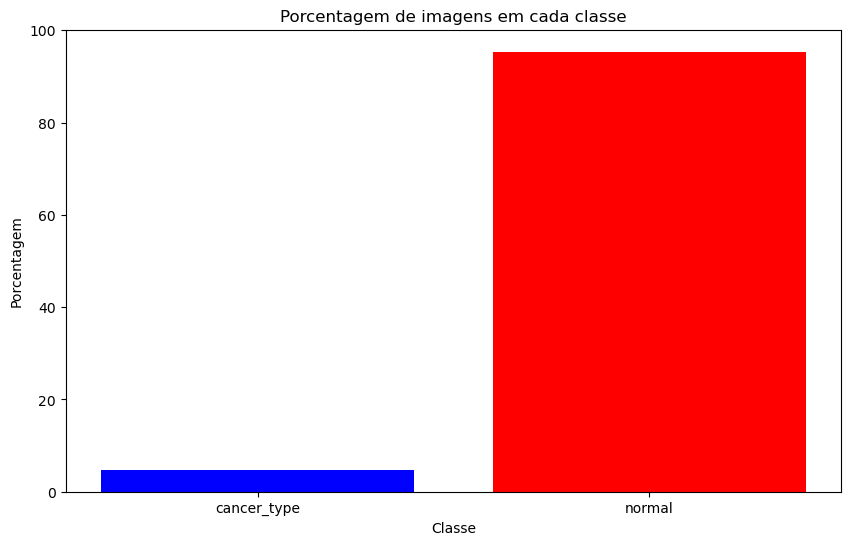

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type         200     4.641448
normal             4109    95.358552


In [3]:
#Train set binário sem data augmentation
folder_path = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/train'
plot_image_counts2(folder_path)

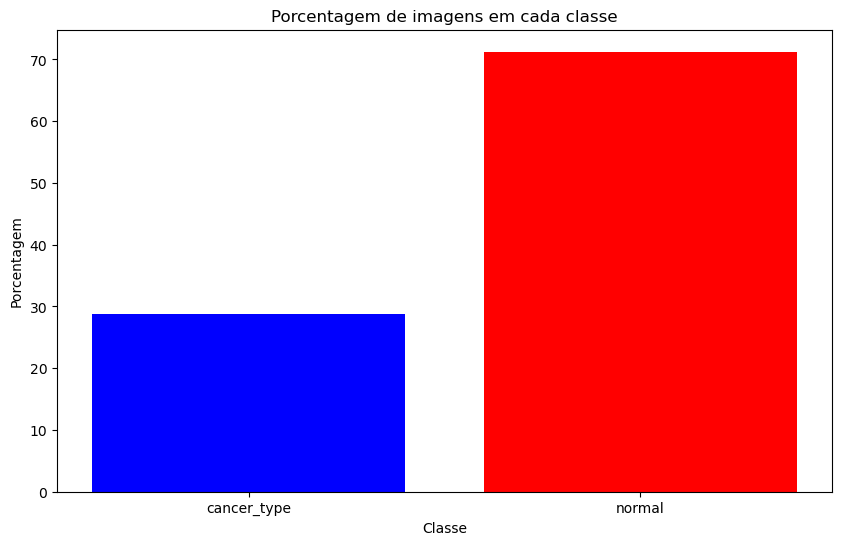

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type         121    28.741093
normal              300    71.258907


In [4]:
#Test set binário
folder_path = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/test'
plot_image_counts2(folder_path)

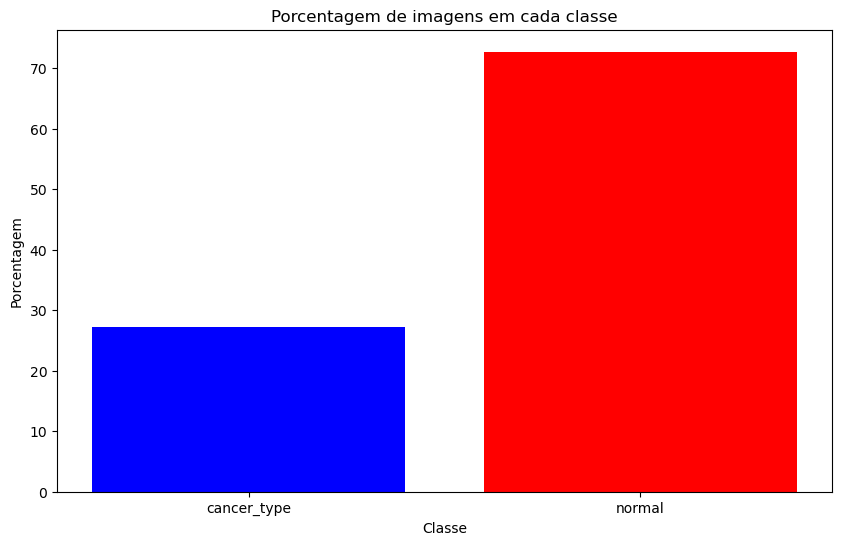

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type          75    27.272727
normal              200    72.727273


In [5]:
#Val set binário
folder_path = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/val'
plot_image_counts2(folder_path)

In [6]:
#Diretórios
train_dir = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/train'
val_dir = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/val'
test_dir = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/test'

#Set das dimensões
img_width, img_height = 1890//4, 2457//4 
input_shape = (img_width, img_height, 3)

#Batch size
batch_size = 16

#CLasses
num_classes = 2

In [7]:
#Data generators
#train_datagen = ImageDataGenerator(rescale=1./255)
#val_datagen = ImageDataGenerator(rescale=1./255)
#test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
val_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False)

Found 4309 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 421 images belonging to 2 classes.


In [8]:
#Transfer learning com a resnet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 2 classes
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid') 
])

total = 200 + 4109
weight_for_0 = (1 / 200) * (total / 2.0)
weight_for_1 = (1 / 4109) * (total / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}

In [9]:
#lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001, verbose=1)
adam = Adam(learning_rate=0.0005)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
#FAZER DEPOIS COM 0.0001

In [10]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose = 1, restore_best_weights=True)

In [11]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping])

Epoch 1/100


/home/breno/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


270/270 ━━━━━━━━━━━━━━━━━━━━ 978s 4s/step - accuracy: 0.7476 - loss: 25.1743 - val_accuracy: 0.6873 - val_loss: 39.9081
Epoch 2/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 957s 4s/step - accuracy: 0.9441 - loss: 2.8105 - val_accuracy: 0.7309 - val_loss: 63.9533
Epoch 3/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 958s 4s/step - accuracy: 0.9558 - loss: 2.1357 - val_accuracy: 0.7200 - val_loss: 67.6170
Epoch 4/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 958s 4s/step - accuracy: 0.9752 - loss: 0.9349 - val_accuracy: 0.7236 - val_loss: 74.5715
Epoch 5/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 958s 4s/step - accuracy: 0.9836 - loss: 0.5263 - val_accuracy: 0.7236 - val_loss: 89.2340
Epoch 6/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 958s 4s/step - accuracy: 0.9888 - loss: 0.4689 - val_accuracy: 0.6727 - val_loss: 61.4827
Epoch 7/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 958s 4s/step - accuracy: 0.9898 - loss: 0.3705 - val_accuracy: 0.7164 - val_loss: 96.1728
Epoch 8/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 982s 4s/step - accuracy: 0.9918 - loss: 0.4653 - val_

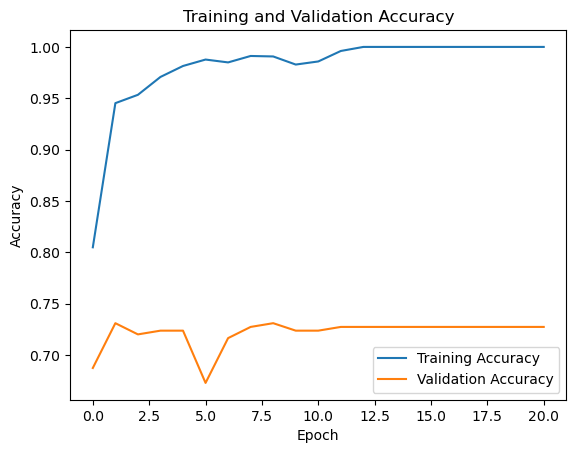

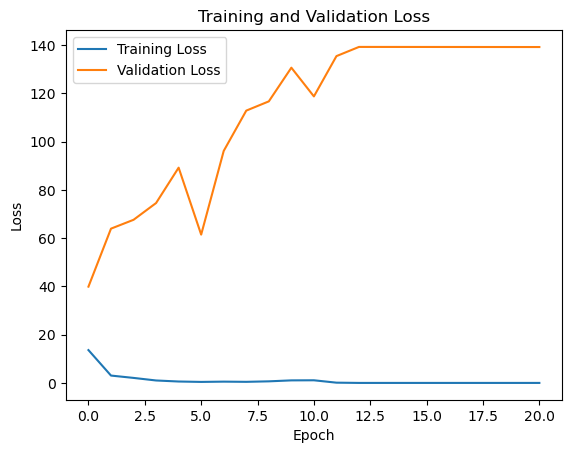

In [12]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.8766 - loss: 7.3767
Test Accuracy: 90.02%
Test Loss: 5.3596


In [14]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
#predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = (predictions > 0.5).astype(int).flatten()
predicted_labels

27/27 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [15]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

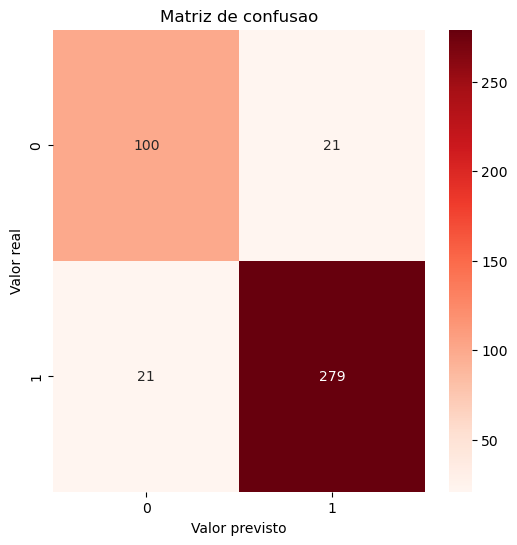

In [16]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [17]:
accuracy_from_confusion = np.trace(confusion) / np.sum(confusion)
print(f'Precisao da matriz de confusao: {accuracy_from_confusion * 100:.2f}%')

Precisao da matriz de confusao: 90.02%


In [18]:
#True negative, false positive, false negative, true positive.
TP, FN, FP, TN = confusion.ravel()

#Sensitivity a partir da definicao
sensitivity = TP / (TP + FN)
print(sensitivity)

#Specifity da definicao
specificity = TN / (TN + FP)
print(specificity)


0.8264462809917356
0.93


In [19]:
#Data generators

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#train_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
#val_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
#test_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False)

Found 4309 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 421 images belonging to 2 classes.


In [20]:
#Transfer learning com a densenet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 2 classes
for layer in base_model.layers:
    layer.trainable = False

#Mais simples possivel - apenas com uso do softmax final
model = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid') 
])

total = 200 + 4109
weight_for_0 = (1 / 200) * (total / 2.0)
weight_for_1 = (1 / 4109) * (total / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}


In [21]:
#Compilar o modelo
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose = 1, restore_best_weights=True)

In [23]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping])

Epoch 1/100


/home/breno/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


270/270 ━━━━━━━━━━━━━━━━━━━━ 1054s 4s/step - accuracy: 0.7107 - loss: 12.8725 - val_accuracy: 0.6036 - val_loss: 13.1226
Epoch 2/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1035s 4s/step - accuracy: 0.9118 - loss: 2.0396 - val_accuracy: 0.6800 - val_loss: 23.1693
Epoch 3/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1037s 4s/step - accuracy: 0.9535 - loss: 0.8181 - val_accuracy: 0.7273 - val_loss: 33.9910
Epoch 4/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1039s 4s/step - accuracy: 0.9607 - loss: 1.3183 - val_accuracy: 0.7127 - val_loss: 32.4563
Epoch 5/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1039s 4s/step - accuracy: 0.9861 - loss: 0.2009 - val_accuracy: 0.6982 - val_loss: 43.9925
Epoch 6/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1039s 4s/step - accuracy: 0.9769 - loss: 0.4204 - val_accuracy: 0.7018 - val_loss: 33.0117
Epoch 7/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1039s 4s/step - accuracy: 0.9638 - loss: 1.1482 - val_accuracy: 0.7127 - val_loss: 44.5513
Epoch 8/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1038s 4s/step - accuracy: 0.9821 - loss: 0.464

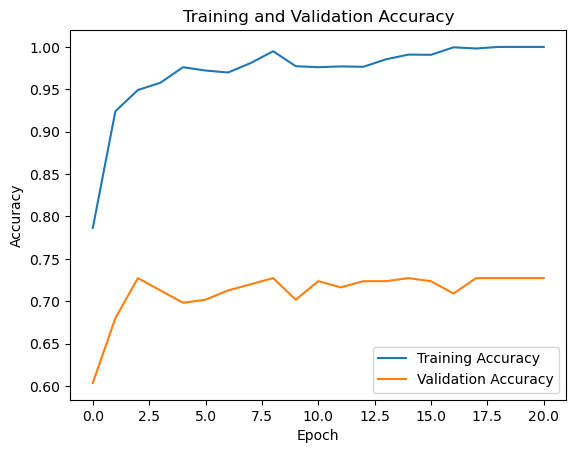

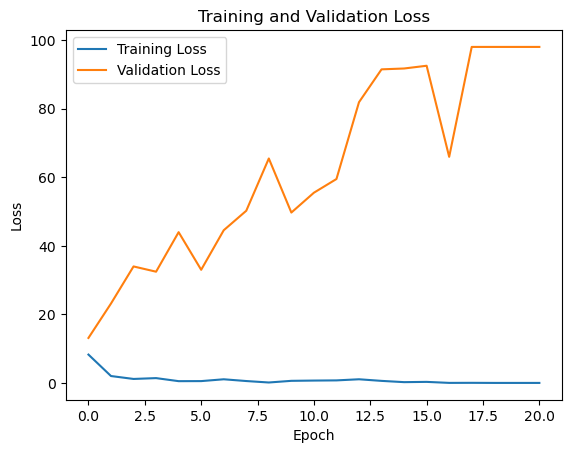

In [24]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.8748 - loss: 2.9392
Test Accuracy: 75.77%
Test Loss: 6.4515


In [26]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
#predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = (predictions > 0.5).astype(int).flatten()
predicted_labels

27/27 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,

In [27]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

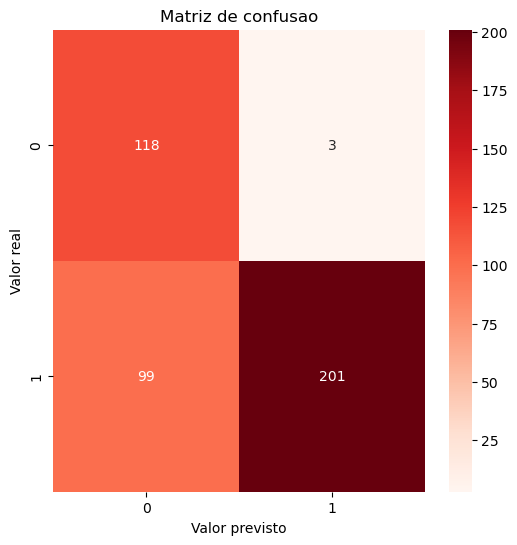

In [28]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [29]:
accuracy_from_confusion = np.trace(confusion) / np.sum(confusion)
print(f'Precisao da matriz de confusao: {accuracy_from_confusion * 100:.2f}%')

Precisao da matriz de confusao: 75.77%


In [30]:
#True negative, false positive, false negative, true positive.
TP, FN, FP, TN = confusion.ravel()

#Sensitivity a partir da definicao
sensitivity = TP / (TP + FN)
print(sensitivity)

#Specifity da definicao
specificity = TN / (TN + FP)
print(specificity)


0.9752066115702479
0.67


In [31]:
#Transfer learning com a densenet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 2 classes
for layer in base_model.layers:
    layer.trainable = False

#Mais simples possivel - apenas com uso do softmax final
model = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid') 
])

total = 200 + 4109
weight_for_0 = (1 / 200) * (total / 2.0)
weight_for_1 = (1 / 4109) * (total / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}

In [32]:
#Compilar o modelo
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose = 1, restore_best_weights=True)

In [34]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping])

Epoch 1/100


2024-07-02 02:32:28.181766: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1187053568 exceeds 10% of free system memory.
2024-07-02 02:32:28.574804: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1187053568 exceeds 10% of free system memory.


  1/270 ━━━━━━━━━━━━━━━━━━━━ 59:40 13s/step - accuracy: 1.0000 - loss: 0.1706

2024-07-02 02:32:35.280480: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1187053568 exceeds 10% of free system memory.
2024-07-02 02:32:35.635573: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1187053568 exceeds 10% of free system memory.


  2/270 ━━━━━━━━━━━━━━━━━━━━ 31:31 7s/step - accuracy: 1.0000 - loss: 0.1280 

2024-07-02 02:32:42.338848: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1187053568 exceeds 10% of free system memory.


270/270 ━━━━━━━━━━━━━━━━━━━━ 2036s 8s/step - accuracy: 0.6682 - loss: 2.0738 - val_accuracy: 0.7309 - val_loss: 4.7988
Epoch 2/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2033s 8s/step - accuracy: 0.8491 - loss: 0.7082 - val_accuracy: 0.6982 - val_loss: 2.7196
Epoch 3/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2034s 8s/step - accuracy: 0.9116 - loss: 0.3100 - val_accuracy: 0.7309 - val_loss: 4.5141
Epoch 4/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2035s 8s/step - accuracy: 0.9679 - loss: 0.1161 - val_accuracy: 0.7236 - val_loss: 4.7019
Epoch 5/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2035s 8s/step - accuracy: 0.9252 - loss: 0.5328 - val_accuracy: 0.7345 - val_loss: 4.6863
Epoch 6/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2063s 8s/step - accuracy: 0.9761 - loss: 0.0876 - val_accuracy: 0.7345 - val_loss: 4.5300
Epoch 7/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2038s 8s/step - accuracy: 0.9811 - loss: 0.0740 - val_accuracy: 0.7273 - val_loss: 5.8029
Epoch 8/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2034s 8s/step - accuracy: 0.9993 - loss: 0.0021 - val_

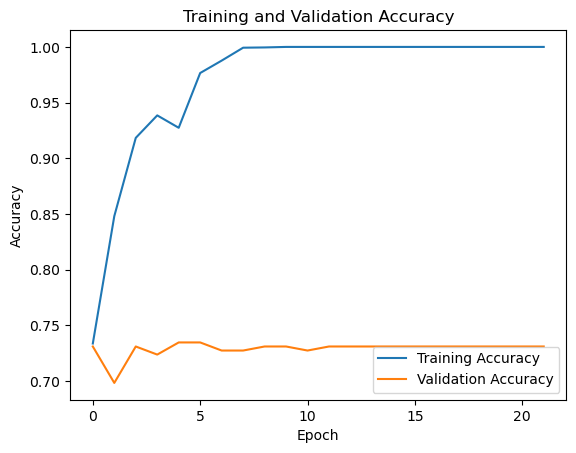

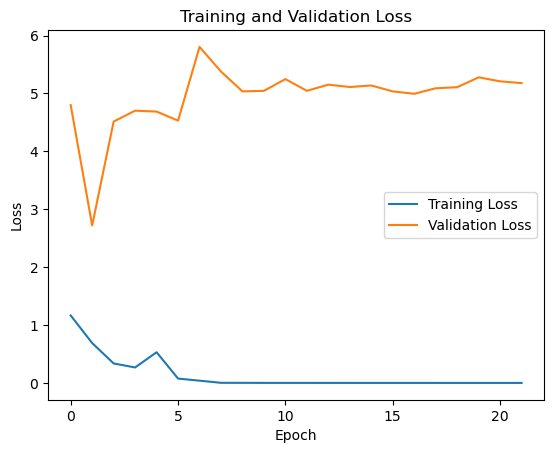

In [35]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 188s 7s/step - accuracy: 0.8808 - loss: 0.4943
Test Accuracy: 90.26%
Test Loss: 0.3550


In [37]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
#predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = (predictions > 0.5).astype(int).flatten()
predicted_labels

27/27 ━━━━━━━━━━━━━━━━━━━━ 188s 7s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [38]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

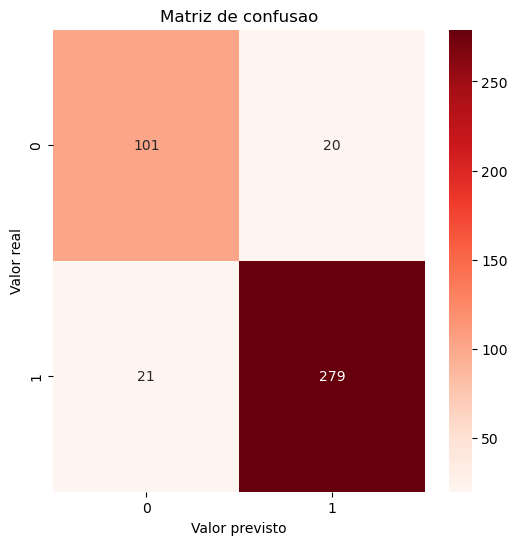

In [39]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [40]:
accuracy_from_confusion = np.trace(confusion) / np.sum(confusion)
print(f'Precisao da matriz de confusao: {accuracy_from_confusion * 100:.2f}%')

Precisao da matriz de confusao: 90.26%


In [41]:
#True negative, false positive, false negative, true positive.
TP, FN, FP, TN = confusion.ravel()

#Sensitivity a partir da definicao
sensitivity = TP / (TP + FN)
print(sensitivity)

#Specifity da definicao
specificity = TN / (TN + FP)
print(specificity)


0.8347107438016529
0.93


A partir dos resultados, percebe-se que o modelo esta indo bem no teste, pois chega em um overfitting, mas muito mal na validacao em todos os modelos. Por algum motivo, todos os modelos tambem estao indo bem no teste.